# Type Model
Prepare the Data

In [2]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob



In [39]:
# setup data 
image_list = []
    # -3 means back one directory
# filename/shape/type/label
for filepath in glob.glob('images/*/*/*.png', recursive=True):
     filename = filepath.split("\\")[-1]
     sign_shape = filepath.split("\\")[-2]
     sign_type = filepath.split("\\")[-3]
     
     image_list.append((filepath,sign_shape,sign_type))
     
data = pd.DataFrame(data=image_list, columns=['image_path','sign_type', 'sign_shape'])


Dataframes for training and validation

In [34]:
r_inx = np.random.choice(100, 4)
rand_data = data.loc[r_inx,'image_path']


d = {'rightofway':0, 'stop':1, 'bicycle':2,
     'limitedtraffic':3, 'noentry':4, 'noparking':5,
     'roundabout':6, 'speed':7,'trafficdirective':8,
     'traveldirection':9,'continue':10,'crossing':11,
     'laneend':12, 'parking':13, 'giveway':14, 'warning':15}
data['type_num'] = data['sign_type'].map(d, na_action='ignore')

print(data)

train, validate, test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])


N_train_images = train.shape[0]
N_val_images = validate.shape[0]
N_test_images = test.shape[0]

                                     image_path   sign_type sign_shape  \
0     images\diamond\rightofway\00032_00000.png  rightofway    diamond   
1     images\diamond\rightofway\00032_00001.png  rightofway    diamond   
2     images\diamond\rightofway\00032_00002.png  rightofway    diamond   
3     images\diamond\rightofway\00037_00000.png  rightofway    diamond   
4     images\diamond\rightofway\00037_00001.png  rightofway    diamond   
...                                         ...         ...        ...   
3694    images\triangle\warning\01947_00001.png     warning   triangle   
3695    images\triangle\warning\01947_00002.png     warning   triangle   
3696    images\triangle\warning\01971_00000.png     warning   triangle   
3697    images\triangle\warning\01971_00001.png     warning   triangle   
3698    images\triangle\warning\01971_00002.png     warning   triangle   

      type_num  
0            0  
1            0  
2            0  
3            0  
4            0  
...      

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=10, width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')
                                
                                   
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=10, width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')


batch_size = 72

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validate,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical', shuffle=False
)


Found 2219 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy, sparse_categorical_crossentropy, sparse_categorical_accuracy


In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers, optimizers
from keras.layers import GaussianNoise

# 0.001
# TODO tryt 1e-7
sgd = optimizers.SGD(lr=0.01, decay=0.001, momentum=0.9, nesterov=True)

model = Sequential()
chanDim = -1

# input
model.add(Input(shape=(28, 28, 3)))
model.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

model.add(Conv2D(8, (5, 5),kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# first set of (CONV => RELU => CONV => RELU) * 2 => POOL
model.add(Conv2D(16, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(16, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
# second set of (CONV => RELU => CONV => RELU) * 2 => POOL
model.add(Conv2D(32, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.001)))
# model.add(Activation("relu"))
# model.add(BatchNormalization(axis=chanDim))
# model.add(Conv2D(64, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.001)))
# model.add(Activation("relu"))
# model.add(BatchNormalization(axis=chanDim))
# model.add(MaxPooling2D(pool_size=(2, 2),padding="same"))


# first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128,kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# second set of FC => RELU layers
model.add(Dense(128,kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(16))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model.summary()

Using TensorFlow backend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 8)         208       
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 24, 24, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 10, 10, 16)        0

In [8]:
def calculate_losses(model_in, data_generator_in, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0

    # iterate over each batch
    for x,y in data_generator_in:
        loss, acc = model_in.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because the generator loops indefinitely
            break

    return np.mean(loss_hold), np.mean(acc_hold)


def train_model_two(model_, num_epoch=90, verbose=False):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))

    model_.save('model2.h5')
    print('Model saved')

    return np.asarray(res)



res_two = train_model_two(model, num_epoch=90, verbose=True)



def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])


Training epoch 0: Loss = 3.909264326095581, Accuracy = 0.12608590722084045
Validation epoch 0: Loss = 4.042646723564225, Accuracy = 0.17904041707515717
Training epoch 1: Loss = 3.0262351036071777, Accuracy = 0.22950656712055206
Validation epoch 1: Loss = 2.7871543831295438, Accuracy = 0.27525249123573303
Training epoch 2: Loss = 2.581425189971924, Accuracy = 0.3236147463321686
Validation epoch 2: Loss = 2.3455887454928774, Accuracy = 0.3623737394809723
Training epoch 3: Loss = 2.312798261642456, Accuracy = 0.3912736475467682
Validation epoch 3: Loss = 2.2756457437168467, Accuracy = 0.4131312668323517
Training epoch 4: Loss = 2.087205171585083, Accuracy = 0.4618845283985138
Validation epoch 4: Loss = 2.4574650778914946, Accuracy = 0.32777777314186096
Training epoch 5: Loss = 1.9129717350006104, Accuracy = 0.5090391635894775
Validation epoch 5: Loss = 2.17173973719279, Accuracy = 0.4762625992298126
Training epoch 6: Loss = 1.823974847793579, Accuracy = 0.5417439341545105
Validation epoch

Predict Model 2

1


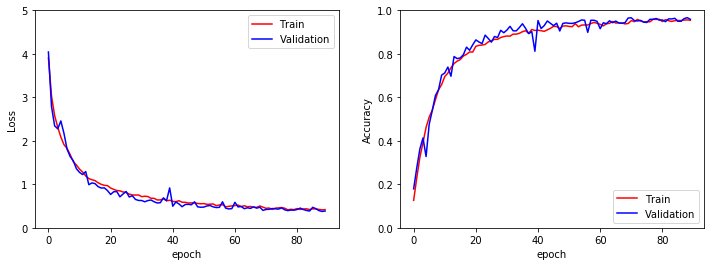

In [15]:
plot_results(res_two)


pred = model.predict(test_generator)
print(np.argmax(pred[0]))

predicted_class_indices=np.argmax(pred,axis=1)

print(test_generator)

labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())

predictions = [labels[k] for k in predicted_class_indices]


Results on test data

In [10]:
# TODO load model for easier testing

In [38]:
# test classes
test_classes = np.array(test_generator.classes)

test_labels = test_generator.class_indices
test_labels = dict((v,k) for k,v in test_labels.items())

test_class = [test_labels[k] for k in test_classes]


filenames=test_generator.classes

results=pd.DataFrame({"Filename":test_classes,
                      "Predictions":predicted_class_indices})
print(results)


tests = model.evaluate(test_generator)
print(tests)

     Filename  Predictions
0           1            1
1           1            1
2           7            7
3           3            3
4           5            5
..        ...          ...
735         1            1
736         3            3
737         0            0
738        15           15
739         6            6

[740 rows x 2 columns]
  ...
    to  
  ['...']
11/11 [==============================] - 3s 288ms/step - loss: 0.3604 - categorical_accuracy: 0.9716

## loss: 0.3604 - categorical_accuracy: 0.9716 on testing 
 now for...
# Real World Data

In [69]:

from PIL import Image
from resizeimage import resizeimage

image_list = []
    # -3 means back one directory
# filename/shape/type/label
for filepath in glob.glob('Test/*/*/*.png', recursive=True):
     filename = filepath.split("\\")[-1]
     sign_shape = filepath.split("\\")[-2]
     sign_type = filepath.split("\\")[-3]
     
     image_list.append((filepath,sign_type,sign_shape))
     
real_word_data = pd.DataFrame(data=image_list, columns=['image_path','sign_shape', 'sign_type'])


d = {'rightofway':0, 'stop':1, 'bicycle':2,
     'limitedtraffic':3, 'noentry':4, 'noparking':5,
     'roundabout':6, 'speed':7,'trafficdirective':8,
     'traveldirection':9,'continue':10,'crossing':11,
     'laneend':12, 'parking':13, 'giveway':14, 'warning':15}

real_word_data['shapes_num'] = real_word_data['sign_type'].map(d, na_action='ignore')

print(real_word_data)

                                        image_path sign_shape   sign_type  \
0    Test\diamond\rightofway\00012_00000_00001.png    diamond  rightofway   
1    Test\diamond\rightofway\00012_00000_00002.png    diamond  rightofway   
2    Test\diamond\rightofway\00012_00000_00003.png    diamond  rightofway   
3    Test\diamond\rightofway\00012_00000_00004.png    diamond  rightofway   
4    Test\diamond\rightofway\00012_00000_00005.png    diamond  rightofway   
..                                             ...        ...         ...   
801    Test\triangle\warning\00029_00003_00026.png   triangle     warning   
802    Test\triangle\warning\00030_00002_00023.png   triangle     warning   
803    Test\triangle\warning\00030_00002_00027.png   triangle     warning   
804    Test\triangle\warning\00030_00003_00008.png   triangle     warning   
805    Test\triangle\warning\00030_00003_00019.png   triangle     warning   

     shapes_num  
0             0  
1             0  
2             0  
3  

In [70]:
# grey scale
for image_path in real_word_data['image_path']:
    img = Image.open(image_path).convert('LA')
    img.save(image_path)


# Resize images
for image_path in real_word_data['image_path']:
    with open(image_path, 'r+b') as f:
        with Image.open(f) as image:
            cover = resizeimage.resize_cover(image, [28, 28])
            cover.save(image_path, image.format)


In [68]:
#Image Setup

real_test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')


real_test_generator = real_test_datagen.flow_from_dataframe(
        dataframe=real_word_data,
        directory='./',
        x_col="image_path",
        y_col="sign_type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical', shuffle=False
)



real_pred = model.predict(real_test_generator)


real_predicted_class_indices=np.argmax(real_pred,axis=1)

# test classes
real_test_classes = np.array(real_test_generator.classes)

real_test_labels = real_test_generator.class_indices
real_test_labels = dict((v,k) for k,v in real_test_labels.items())

real_test_class = [real_test_labels[k] for k in real_test_classes]


filenames=real_test_generator.classes

results=pd.DataFrame({"Filename":real_test_classes,
                      "Predictions":real_predicted_class_indices})
print(results)


tests = model.evaluate(real_test_generator)
print(tests)


Found 762 validated image filenames belonging to 16 classes.
     Filename  Predictions
0           9            9
1           9            9
2           9            9
3           9            9
4           9            9
..        ...          ...
757        15           15
758        15           15
759        15           15
760        15           15
761        15           15

[762 rows x 2 columns]
  ...
    to  
  ['...']
11/11 [==============================] - 1s 74ms/step - loss: 1.4143 - categorical_accuracy: 0.6850

loss: 1.4143 - categorical_accuracy: 0.6850
